# Using clustering to improve the Zestimate logerror

## Goal:

Improve our original estimate of the log error by using clustering methodologies

## Executive Summary 

We gain a lot of useful insight and knowledge in the exploration phase, and clustering allowed us to visualize the data in new and exiting ways. Unfortunately, it is very hard to predict the logerror, as it is fairly close to zero, and in general, the baseline performs about the same as the models. 

We recommend using the baseline, as Zillow has a strong model, with low logerror variance. 

## Hypthesis:

* $H_0$: Features that represent property size, location, and quality are not good indicators for predicting logerror
* $H_a$: Features that represent property size, location, and quality are good indicators for predicting logerror

## Imports

In [1]:
# General
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# py files
import prepare
import env
import model
import explore
import preprocessing

# Prep
from sklearn.model_selection import train_test_split
from scipy import stats

# Explore
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

# Evaluation
from sklearn.metrics import explained_variance_score
import sklearn.metrics
from math import sqrt

# Prep

The steps taken to prepare the data were as follows:

1. The data was read from SQL by using the following query:

``` 
SELECT *
FROM properties_2017
JOIN (
	SELECT parcelid, `logerror`, max(transactiondate)
	FROM predictions_2017
	GROUP BY parcelid, logerror) predictions_2017 USING (parcelid)
LEFT JOIN `typeconstructiontype` USING (typeconstructiontypeid)
LEFT JOIN propertylandusetype USING (propertylandusetypeid)
LEFT JOIN airconditioningtype USING (airconditioningtypeid)
LEFT JOIN architecturalstyletype USING (architecturalstyletypeid)
LEFT JOIN buildingclasstype USING (buildingclasstypeid)
LEFT JOIN `heatingorsystemtype` USING (`heatingorsystemtypeid`)
LEFT JOIN storytype USING (`storytypeid`)
WHERE latitude IS NOT NULL AND longitude IS NOT NULL
;

```

We focused on properties that had a transaction date of 2017, and to reduce duplicates, we only limited the query to properties with the latest transaction date. 

We used left joins to merge additional information, but ensured that there were no nulls for longitude and latitude. 

2. After we pulled the data, we removed any columns that had more than 50% null values. 

    * We also used the `fips` data to add geographical information, like county and state


3. We turn the following features into object data types

    * `heatingorsystemtypeid`, `parcelid`, `id`, `fips`, `latitude`, `longitude`, `yearbuilt`, `assessmentyear`, `censustractandblock`, `regionidcity`, `regionidzip`, `regionidcounty`, `propertylandusetypeid`
    
4. Next, we imputed null values:

Feature | Impude Method
--------|-------------- |
`heatingorsystemdesc` | Filled NA with "None" |
`buildingqualitytypeid` | Filled NA with the mode (8.0) |
`unitcnt` | Used `propertylandusedesc` to estimate they if they were single units |
`finishedsquarefeet12` | Filled NA with Median | 
`regionidcity` | Filled NA with mode |
`censustractandblock` | Filled NA with mode |
`calculatedfinishedsquarefeet` | Filled NA with median |
`yearbuilt` | Filled NA with mode |

5. Outliers

    * We used percentile to drop any features above the 99th percentile for:
        * `lotsizesquarefeet`
        * `taxamount`
        * `taxvaluedollarcnt`
        
    * The reason for this was because we had predicted that these values would be really helpful at predicitng our target value, but they had over a 1,000 outliers, particularly `lotsizesquarefeet`, so we decided to drop them, particularly so that we could see more granularity when exploring the data.
    
6. Drop Unnecesary Columns

    * Lastly, we dropped columns that we thought had captured the information else where. For example `calculatedbathnbr` had a  0.4% difference from `bathrommcnt`, so we decided that we could keep `bathroomcnt` and drop `calculatedbathnbr`.
        * `propertyzoningdesc`
        * `calculatedbathnbr`
        * `fullbathcnt`
        * `heatingorsystemtypeid`

In [2]:
zillow = prepare.wrangle_zillow()

In [3]:
zillow.shape

(53746, 32)

In [4]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53746 entries, 0 to 53745
Data columns (total 32 columns):
propertylandusetypeid           53746 non-null object
parcelid                        53746 non-null object
id                              53746 non-null object
bathroomcnt                     53746 non-null float64
bedroomcnt                      53746 non-null float64
buildingqualitytypeid           53746 non-null float64
calculatedfinishedsquarefeet    53746 non-null float64
finishedsquarefeet12            53746 non-null float64
fips                            53746 non-null int64
latitude                        53746 non-null object
longitude                       53746 non-null object
lotsizesquarefeet               53746 non-null float64
propertycountylandusecode       53746 non-null object
rawcensustractandblock          53746 non-null float64
regionidcity                    53746 non-null float64
regionidcounty                  53746 non-null object
regionidzip         

## Feature Engineering

Given our hypothesis, and other key insights that we gathered from exploration, we engieneered our own features to help with modeling. 

    * `age_home`: The age of the house in years as of 2017
    * `total_size`: The total size of the property (`lotsizesquarefeet` + `calculatedsquarefeet12`)
    * `value_ratio`: That is the rate between home tax and property tax
    * `tax_rate`: The `tax amount` / `taxdollarcount`

We also used kmeans clustering to create new clusters that could helps us better understand the relationships in the data. We used clustering to also create new features:

* Created new clusters using `longitude`, `latitude` and `tax_rate`, as we found that there was a difference in tax_rate, and by using the mean tax_rate of the centroids, we could predict the level of variance in the `logerror`

In [5]:
zillow = preprocessing.engineer_features(zillow)

# Exploration

* Before exploration, the data was scaled using a MinMaxScaler

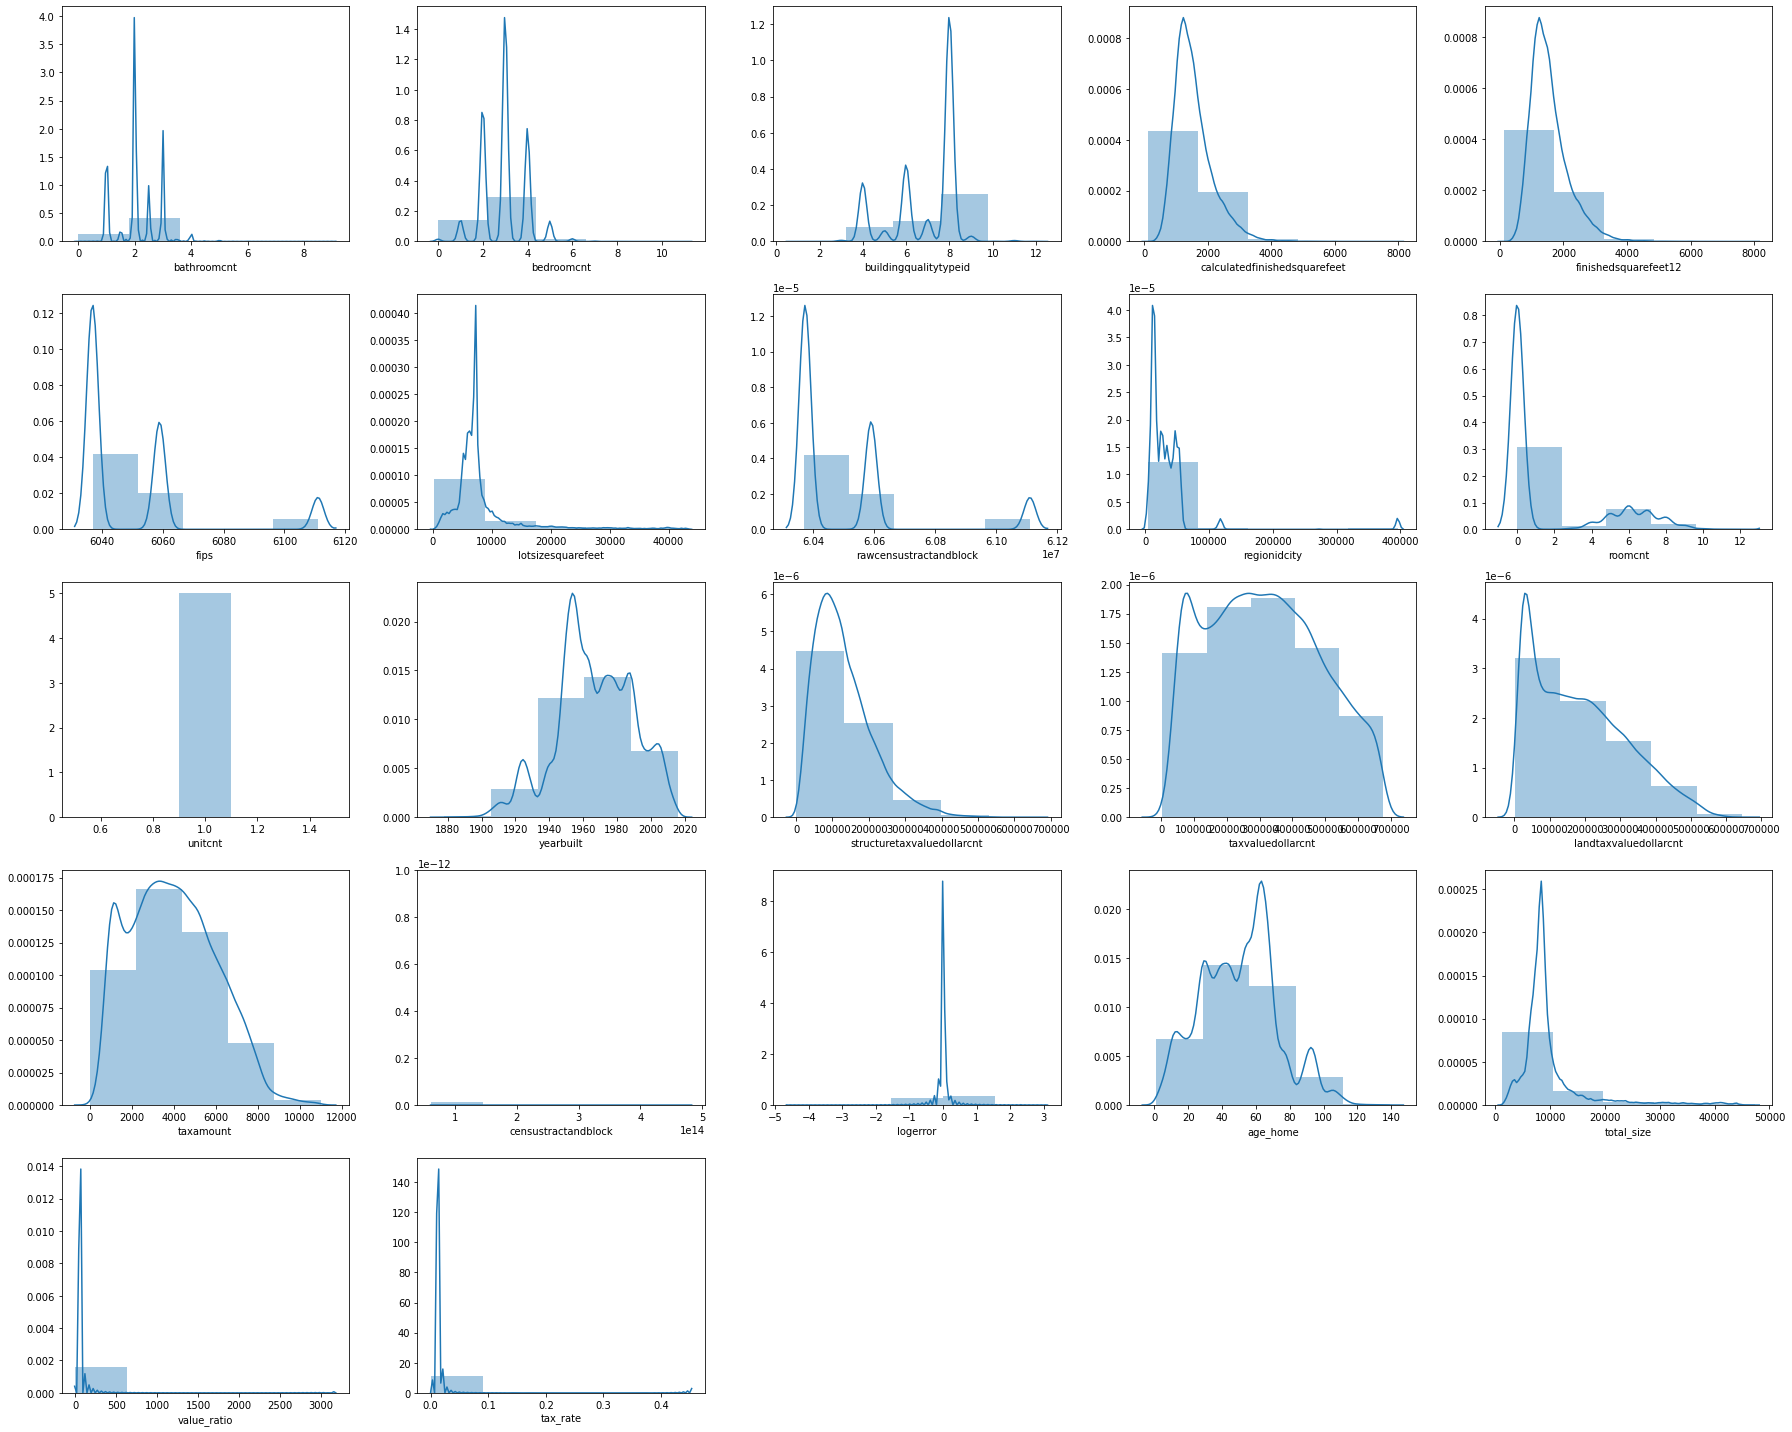

In [6]:
explore.data_distribution(zillow)

### Clustering our Target Variable

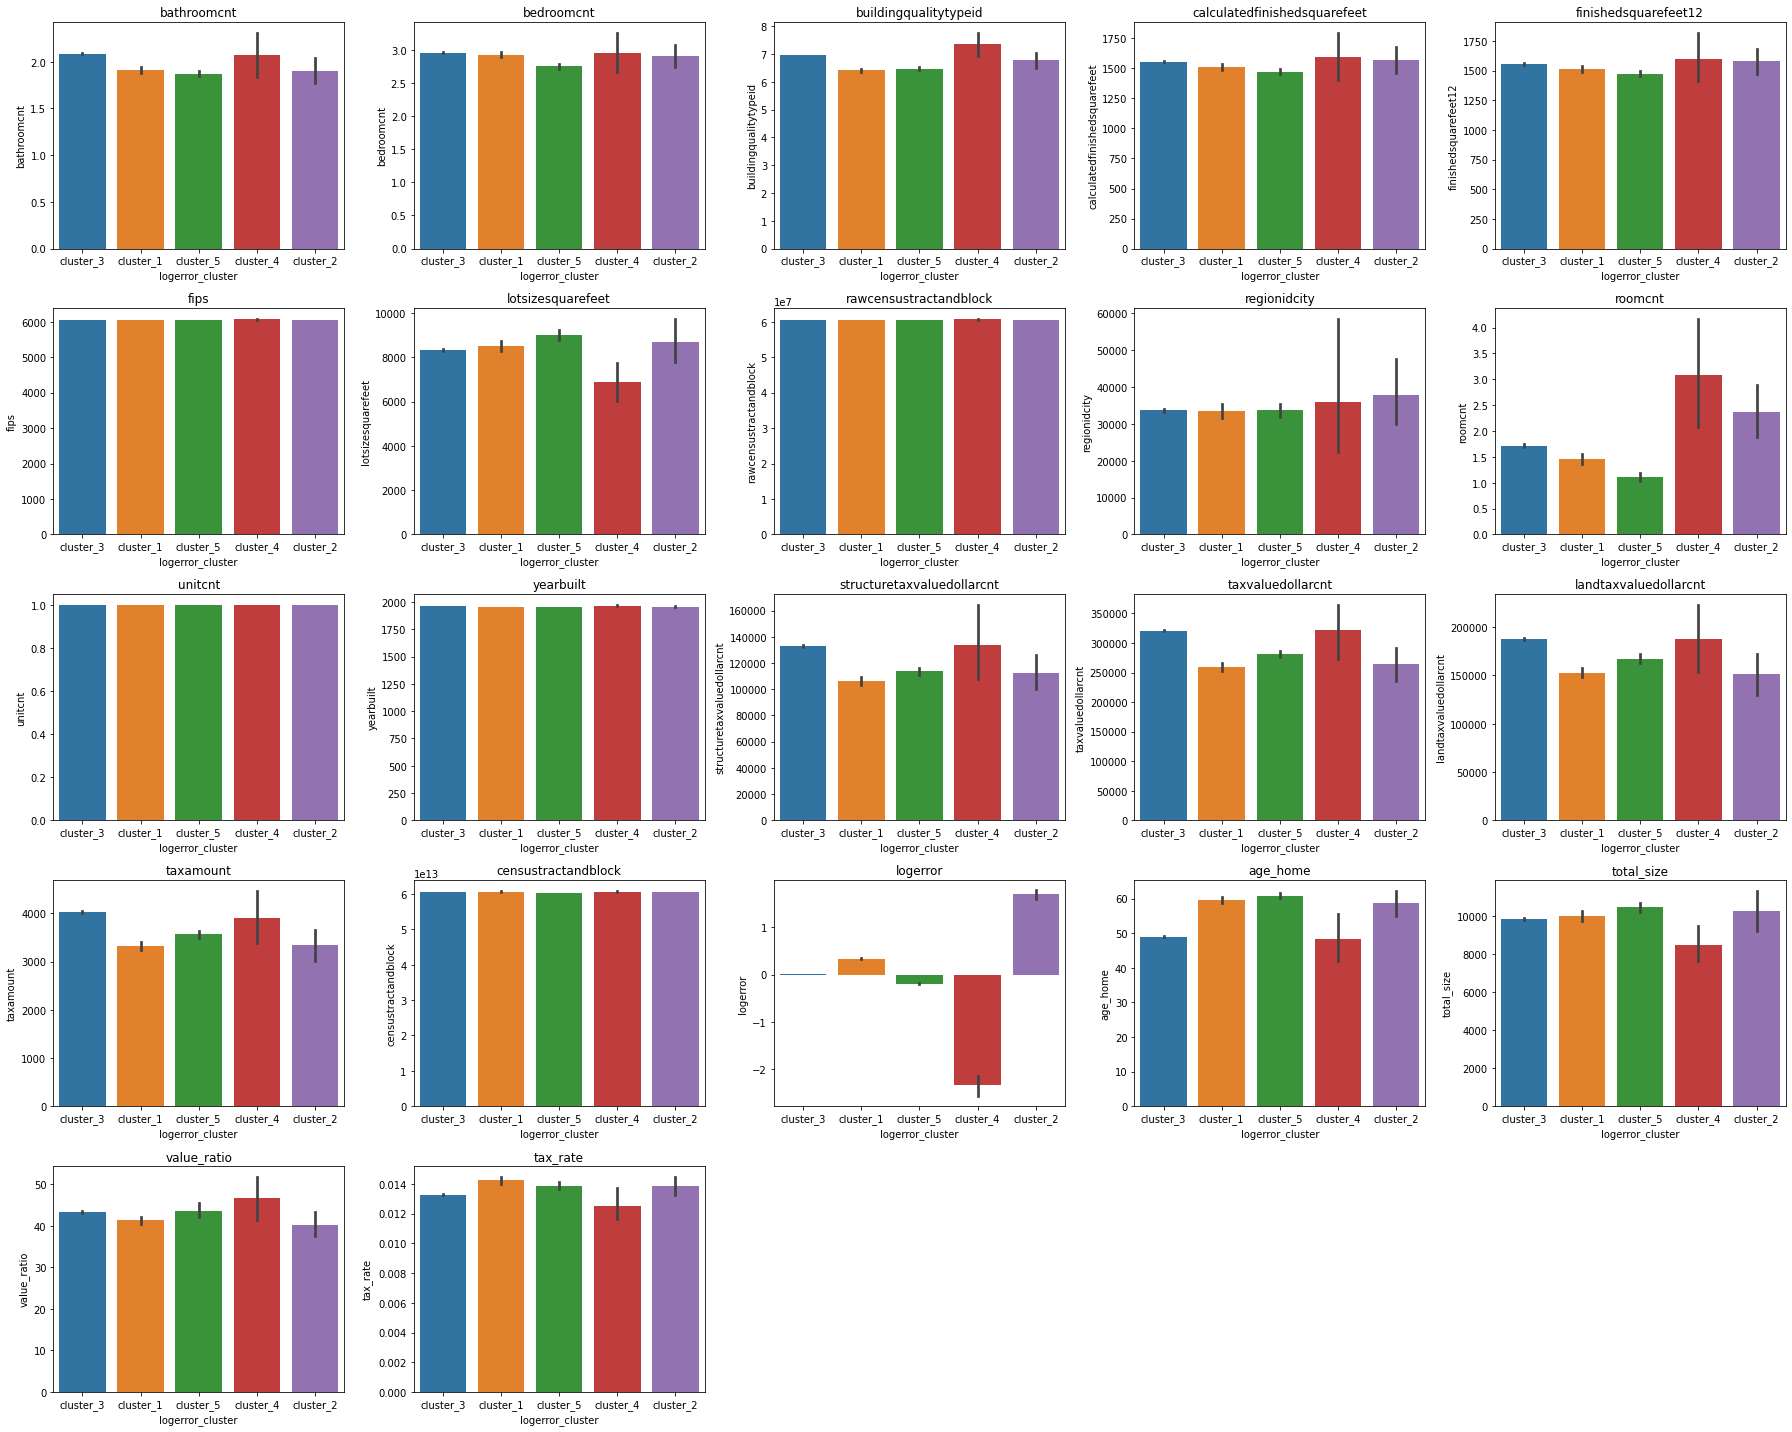

In [7]:
explore.log_error_cluster_groupings(zillow)

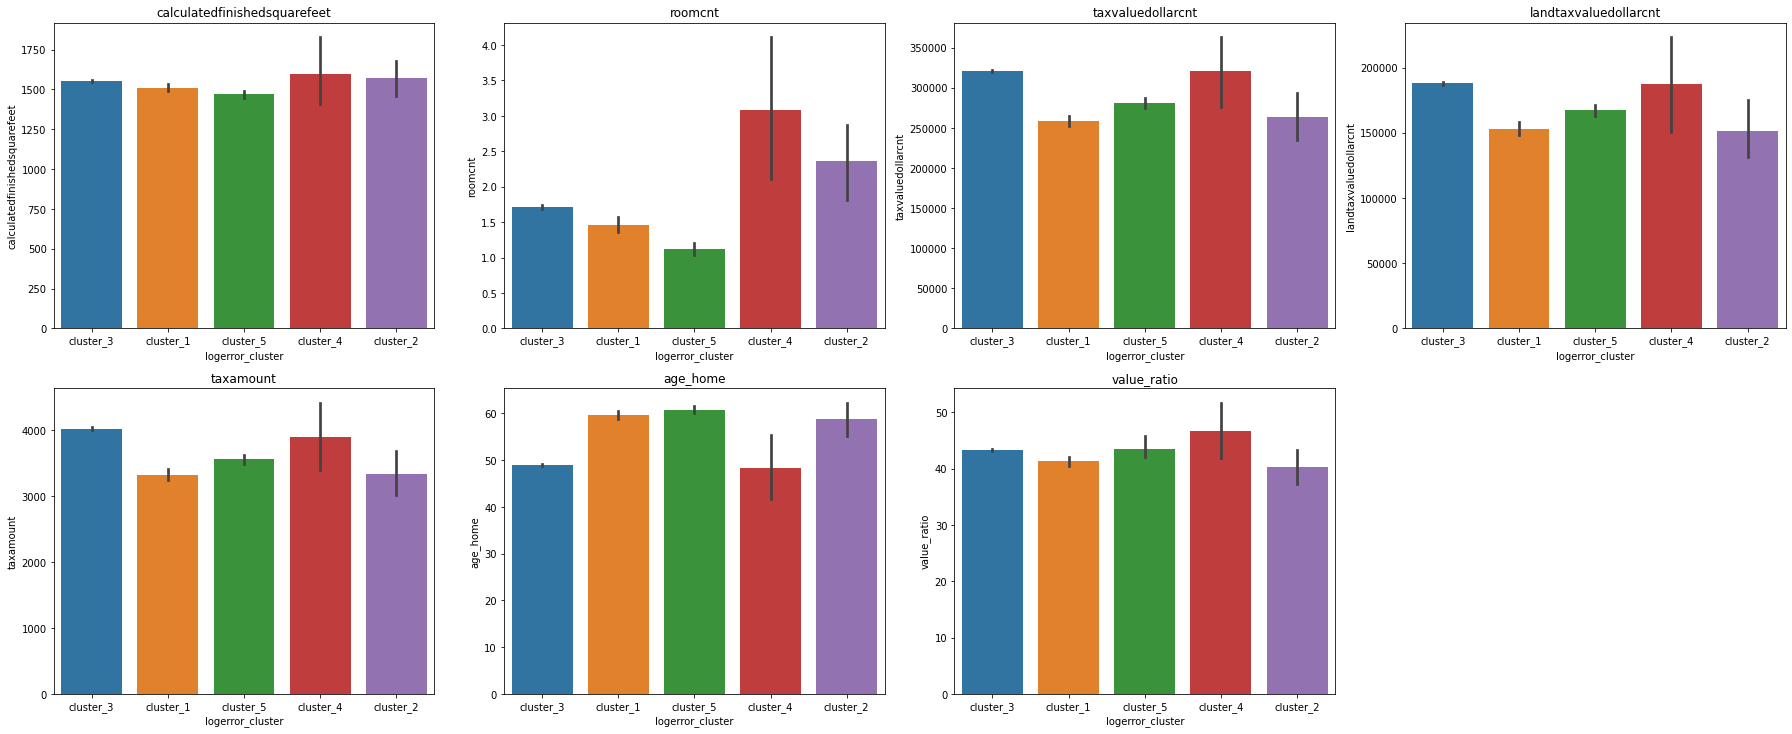

In [8]:
explore.log_error_relationship_clusters(zillow)

The graph above looks to see if there are any clear groupings that could help us identify what is driving logerror. So far, we can see that there are infact some groupings that might help us predict logerror.

* Groupings that have no clear relationship:
    * `bathroomcnt`
    * `bedroomcnt`
    * `buildingqualityid`

This groups don't seem to have a super strong correlation of any kind, as the log error is evently distributed.

* Features that do show a strong relationship: 
    * `calculatedfinishedsquarefeet`
    * `fips`
    * `rawcensusblocktrack`
    * `roomcnt`
    * `taxvaluedollarcnt`
    * `landtaxvaluedollarcnt`
    * `taxamount`
    * `age_home`
    * `value_ratio`
    
These have very distrinct groups, which means we might be able to use them to accurately predict the patterns that can help us model logerror. 

One anomaly to point out - there seems to be that `tax_rate` only shows up in three of the clusters. This is really weird as the values used to derived this features are present in all four clusters.

### Is there a statistical different in mean log error between the different counties? 

* $H_0$: There is no mean difference in log error between the different counties
* $H_a$: There is a statistical difference in log error between the different counties

$\alpha$ = 0.05

In [9]:
# first do a one tail test against the group mean
for i in range(0,3):
    county = zillow.county.value_counts().index[i]
    subgroup = zillow[zillow.county == county].logerror
    tstat, p = stats.ttest_1samp(subgroup, zillow.logerror.mean())
    print(f'{county}, p = {p:.2f}')

Los Angeles, p = 0.46
Orange County, p = 0.30
Ventura County, p = 0.96


We see that Orange County does have a statistically significant difference between it's mean log error and the groups. This is interesting because it can be really useful when indentifying what model to use. 

In [10]:
def ttail_t_test(county_1, county_2):
    alpha = 0.05
    subgroup_1 = zillow[zillow.county == county_1].logerror
    subgroup_2 = zillow[zillow.county == county_2].logerror
    
    tstats, p = stats.ttest_ind(subgroup_1, subgroup_2)
    
    reject = "Because p is less than 0.05, we reject the null hypothesis"
    fail_reject = "Because p is more than 0.05, we fail to reject the null hypothesis"

    if p < alpha:
        print(f'''
            {reject}
            The mean_logerror for LA = {subgroup_1.mean():.2f}
            The mean_logerror for Orange County = {subgroup_2.mean():.2}
            ''')
    else:
        print(f'''
            {fail_reject}
            The mean_logerror for LA = {subgroup_1.mean():.2f}
            The mean_logerror for Orange County = {subgroup_2.mean():.2}
            ''')

In [11]:
ttail_t_test("Los Angeles", "Orange County")


            Because p is more than 0.05, we fail to reject the null hypothesis
            The mean_logerror for LA = 0.02
            The mean_logerror for Orange County = 0.017
            


In [12]:
ttail_t_test("Los Angeles", "Ventura County")


            Because p is more than 0.05, we fail to reject the null hypothesis
            The mean_logerror for LA = 0.02
            The mean_logerror for Orange County = 0.016
            


In [13]:
ttail_t_test("Orange County", "Ventura County")


            Because p is more than 0.05, we fail to reject the null hypothesis
            The mean_logerror for LA = 0.02
            The mean_logerror for Orange County = 0.016
            


Oddly, it doesn't seem that there is any significant difference in log error between the two different groups.

### Is there any statistically correlation between the room count and logerror?

* $H_0$: There is no correlation between room count and logerror
* $H_a$: There is a correlation between room count and logerror

$\alpha$ = 0.05

In [14]:
r, p = stats.pearsonr(zillow.roomcnt, zillow.logerror)
print(f"Because our p values is {p:.2f}, we can reject the null hypothesis")
print(f" Our r values is {r:.2f}, so the correlation is not necesarly strong")

Because our p values is 0.00, we can reject the null hypothesis
 Our r values is 0.02, so the correlation is not necesarly strong


### Is there a strong correlation between taxdollarcnt and logerror

* $H_0$: There is no strong correlation between taxdollarcnt and logerror
* $H_a$: There is a strong correlation between taxdollarcnt and logerror

$\alpha$ = 0.05

In [15]:
r, p = stats.pearsonr(zillow.taxvaluedollarcnt, zillow.logerror)
print(f"Because our p values is {p:.2f}, we can reject the null hypothesis")
print(f" Our r values is {r:.2f}, so the correlation is not necesarly strong. Because it is a negative correlation, logerror increases, taxvalue decreases")
print("Likely what this means is that logerror is higher on houses of smaller value")

Because our p values is 0.00, we can reject the null hypothesis
 Our r values is -0.03, so the correlation is not necesarly strong. Because it is a negative correlation, logerror increases, taxvalue decreases
Likely what this means is that logerror is higher on houses of smaller value


## Clustering Exploration

### Location

In [16]:
zillow = preprocessing.create_cluster_centers_tax_location(zillow)

In [17]:
zillow.groupby("tax_location_cluster")["tax_rate_centroid", "latitude_centroid", "longitude_centroid"].mean()

,tax_rate_centroid,latitude_centroid,longitude_centroid
tax_location_cluster,,,
cluster_1,0.017993,3.463190e+07,-1.181266e+08
cluster_2,0.012914,3.410205e+07,-1.183147e+08
cluster_3,0.014380,3.386440e+07,-1.182124e+08
cluster_4,0.011855,3.423868e+07,-1.190680e+08
cluster_5,0.012719,3.378212e+07,-1.179075e+08
cluster_6,0.013937,3.405017e+07,-1.179360e+08
cluster_7,0.013212,3.427291e+07,-1.185623e+08
cluster_8,0.011274,3.359113e+07,-1.176813e+08


### House Age

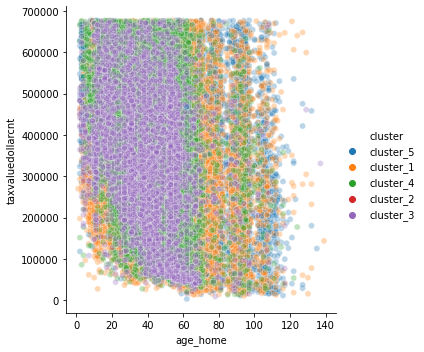

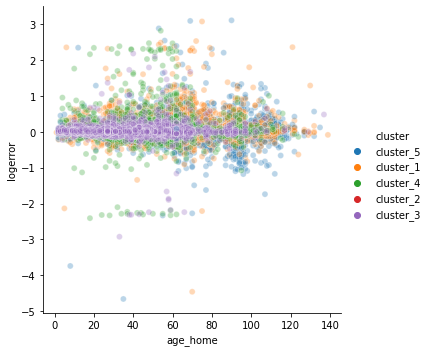

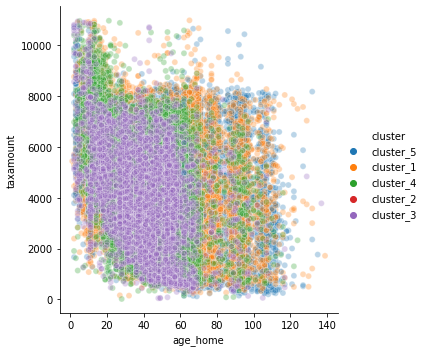

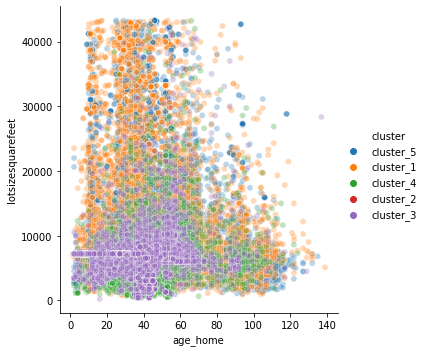

In [18]:
features = ["taxvaluedollarcnt", "logerror", "taxamount", "lotsizesquarefeet"]
explore.k_cluster_relationships(zillow, "age_home", features, 5)

Some key insights to take away:

* There is a clear distinction between fips and our cluster. This likely indicates that ceirtain counties have more newer or older houses. 

* There also seems to be a clear correlation with total_size. The clusters seem to also mirror houses sizes

* Most importantly, however, I there seems to be a faint correlation between `logerror` and our clusters, which is a really positive sign.

### Statistical testing

### Is there a correlation between home age and logerror?

* $H_0$: There is no correlation between home age and logerror
* $H_a$: There is a correlation between home age and logerror

$\alpha$ = 0.05

In [19]:
r, p = stats.pearsonr(zillow.logerror, zillow.age_home)
print(f'''

Because p({p:.2f}) is smaller than our alpha, we  reject the null hypothesis, and assume that there is a 
statistically significant correlation between logerror and home age. 

This doesn't mean that there might not be some correlation within the clusters.
''')



Because p(0.00) is smaller than our alpha, we  reject the null hypothesis, and assume that there is a 
statistically significant correlation between logerror and home age. 

This doesn't mean that there might not be some correlation within the clusters.



### Is there a correlation between home age and taxvaluedollarcnt?

* $H_0$: There is no correlation between home age and taxvaluedollarcnt
* $H_a$: There is a correlation between home age and taxvaluedollarcnt

$\alpha$ = 0.05

In [20]:
r, p = stats.pearsonr(zillow.taxvaluedollarcnt, zillow.age_home)
print(f'''

Because p({p:.2f}) is smaller than our alpha, we reject the null hypothesis, and assume that there is a statistically significant correlation between home age and tax value. 
This is really important because we know the logerror is derived from predicting taxvaluedollarcnt, and hence this might be a really good indication. 

The r value is {r:.2f}, which means that as the age of the house increases, the taxvaluedollarcnt decreases, which 
is a very interesting finding.

''')



Because p(0.00) is smaller than our alpha, we reject the null hypothesis, and assume that there is a statistically significant correlation between home age and tax value. 
This is really important because we know the logerror is derived from predicting taxvaluedollarcnt, and hence this might be a really good indication. 

The r value is -0.27, which means that as the age of the house increases, the taxvaluedollarcnt decreases, which 
is a very interesting finding.




### Property Size

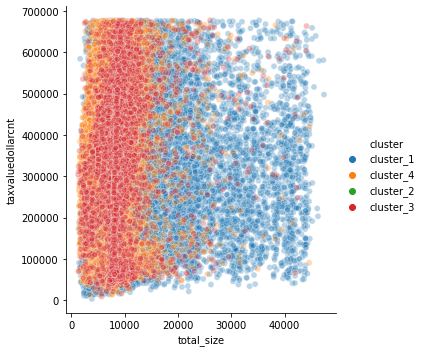

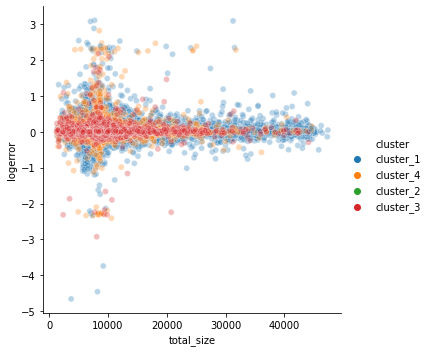

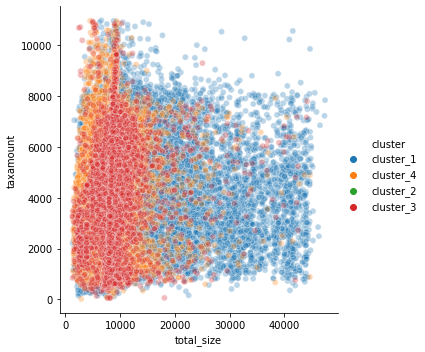

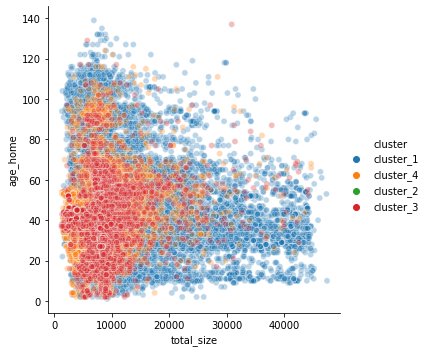

In [21]:
features = ["taxvaluedollarcnt", "logerror", "taxamount", "age_home"]
explore.k_cluster_relationships(zillow, "total_size", features, 4)

There seems to be more correlations with the tax related categories when looking at these clusters. 

* There still seems like there is a really nice distribution between the clusters and the counties.

* There also seems to be a grouping with `year_built`. It might be possible that we can actually further combine these two to create more robust clusters.

#### Statistical Testing:


# Is there a significant correlation between the size of the property and the logerror?

* $H_0$: There is no significant correlation between size of the property and logerror
* $H_a$: There is a significant correlation between size of the property and logerror

$\alpha$ = 0.05

In [23]:
r, p = stats.pearsonr(zillow.total_size, zillow.logerror)

print(f'''

Because p ({p:.2f}) is lower than our alpha, we reject the null hypothesis, and assume that there is a significant
relationship between size and logerror.

Our r values is {r:.2f}, which means there is a not a very strong correlation, but it is a positive one.

''')



Because p (0.04) is lower than our alpha, we reject the null hypothesis, and assume that there is a significant
relationship between size and logerror.

Our r values is 0.01, which means there is a not a very strong correlation, but it is a positive one.




In [24]:
zillow = preprocessing.create_cluster_center_size(zillow)

# Is there a difference in mean log error between the clusters?

* $H_0$: There is no significant difference in mean logerror between the cluster and the group
* $H_a$: There is a significant difference in mean logerror between the clsuters and the group

In [25]:
# first do a one tail test against the group mean
for i in range(0,4):
    cluster = zillow.total_size_cluster.value_counts().index[i]
    subgroup = zillow[zillow.total_size_cluster == cluster].logerror
    tstat, p = stats.ttest_1samp(subgroup, zillow.logerror.mean())
    print(f'{cluster}, p = {p:.2f}')
    

cluster_3, p = 0.59
cluster_1, p = 0.55
cluster_4, p = 0.03
cluster_2, p = 0.63


Cluster_1 does has a statistically significant mean from the group - this could be a very good at predicting logerror.

# Modeling

There will be three models that we wanted to try, both with the same features. 

Features:

* `age_home`
* `total_size`
* `value_ratio`
* `tax_rate_centroid`
* `roomcnt`

Models:

* A Linear Regression Model
* A Random Forest Regressor model
* A Linear Regression Model, with models done by county

## Linear Regression

In [26]:
features = ["age_home", "total_size", "value_ratio", "tax_rate_centroid", "roomcnt", "buildingqualitytypeid"]
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = prepare.prepare_for_modeling(zillow, features)

In [27]:
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mean()}) # beacuse logerror is evenly distributed, we can use the mean as the baseline

In [28]:
lm, y_pred = model.run_lm(train_scaled, y_train)
predictions["linear_regression"] = y_pred

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

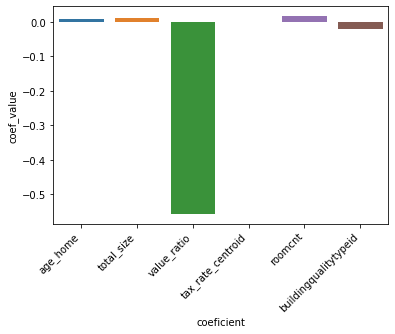

In [29]:
coef = pd.DataFrame({"coeficient": features, "coef_value":lm.coef_})
sns.barplot(data=coef, x="coeficient", y="coef_value")
plt.xticks(rotation=45, ha="right")


In [30]:
r_square = lm.score(train_scaled, y_train)

print(f'The r_square value is {r_square:.5f}')

The r_square value is 0.00121


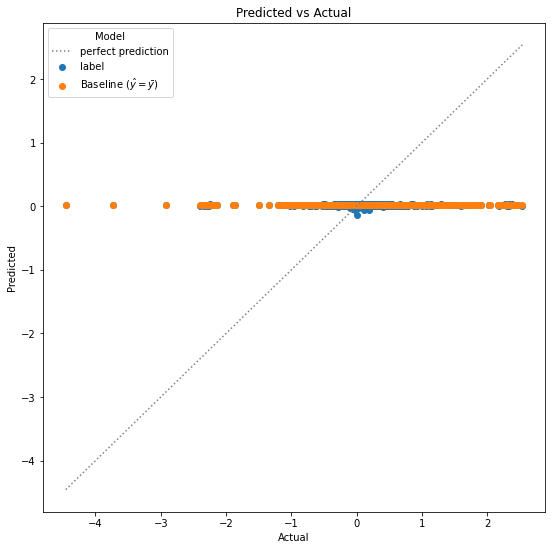

In [31]:
model.print_predicted_vs_actual(predictions, "linear_regression", "Linear Regression Model")

## Random Forest Regressor

In [32]:
features = ["age_home", "total_size", "value_ratio", "tax_rate_centroid", "roomcnt", "buildingqualitytypeid"]
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = prepare.prepare_for_modeling(zillow, features)

In [33]:
rf, y_pred = model.run_rf(train_scaled, y_train, 2, 20)
predictions["random_forest"] = y_pred

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

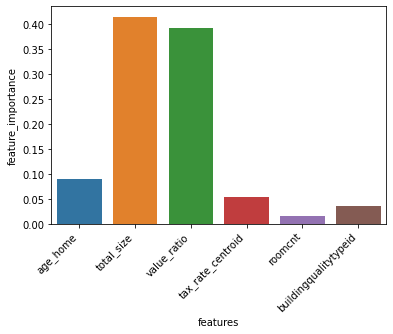

In [34]:
feature_importance = pd.DataFrame({"features": features, "feature_importance": rf.feature_importances_})

sns.barplot(data=feature_importance, x="features", y="feature_importance")
plt.xticks(rotation = 45, ha="right")

In [35]:
# Validate

y_pred = rf.predict(validate_scaled)

mse = sklearn.metrics.mean_squared_error(y_validate, y_pred)
rmse = sqrt(mse)
rmse
r_2 = explained_variance_score(y_validate,y_pred)

r_2

-0.6264253498727723

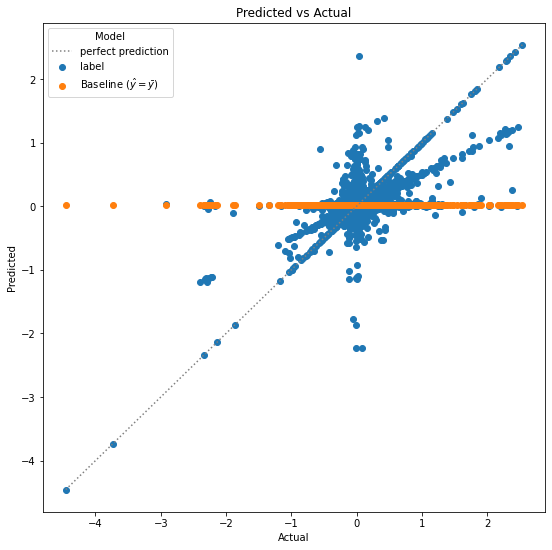

In [36]:
model.print_predicted_vs_actual(predictions, "random_forest", "Linear Regression Model")

## Linear Regression Model by County

### LA Model

In [37]:
county = "Los Angeles"
features = ["age_home", "total_size", "value_ratio", "tax_rate_centroid", "roomcnt"]
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = prepare.prepare_for_modeling_county(zillow,county, features)

In [38]:
predictions_LA = pd.DataFrame({"actual": y_train, "baseline": y_train.mean()}) # beacuse logerror is evenly distributed, we can use the mean as the baseline


In [39]:
lm, y_pred = model.run_lm(train_scaled, y_train)
predictions_LA["linear_regression_LA"] = y_pred


In [40]:
# Evaluate

predictions_LA.apply(lambda col: sklearn.metrics.mean_squared_error(predictions_LA.actual, col))

actual                  0.00000
baseline                0.02349
linear_regression_LA    0.02348
dtype: float64

### Orange County

In [41]:
county = "Orange County"
features = ["age_home", "total_size", "value_ratio", "tax_rate_centroid", "roomcnt"]
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = prepare.prepare_for_modeling_county(zillow,county, features)

In [42]:
predictions_OC = pd.DataFrame({"actual": y_train, "baseline": y_train.mean()}) # beacuse logerror is evenly distributed, we can use the mean as the baseline

In [43]:
lm, y_pred = model.run_lm(train_scaled, y_train)
predictions_OC["linear_regression_OC"] = y_pred

In [44]:
# Evaluate
predictions_OC.apply(lambda col: sklearn.metrics.mean_squared_error(predictions_OC.actual, col))

actual                  0.000000
baseline                0.030607
linear_regression_OC    0.030477
dtype: float64

### Ventura County

In [45]:
county = "Ventura County"
features = ["age_home", "total_size", "value_ratio", "tax_rate_centroid", "roomcnt"]
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = prepare.prepare_for_modeling_county(zillow,county, features)

In [46]:
predictions_VC = pd.DataFrame({"actual": y_train, "baseline": y_train.mean()}) # beacuse logerror is evenly distributed, we can use the mean as the baseline

In [47]:
lm, y_pred = model.run_lm(train_scaled, y_train)
predictions_VC["linear_regression_VC"] = y_pred

In [48]:
# Evaluate

predictions_VC.apply(lambda col: sklearn.metrics.mean_squared_error(predictions_VC.actual, col))

actual                  0.000000
baseline                0.023135
linear_regression_VC    0.023102
dtype: float64

### Combine all feartures and see if it performed better

In [49]:
values = pd.concat([predictions_LA, predictions_OC, predictions_VC])
values["composite_model"] = np.nan
values.composite_model = values.composite_model.fillna(values.linear_regression_LA).fillna(values.linear_regression_VC).fillna(values.linear_regression_OC)

In [50]:
values = values.drop(columns=["linear_regression_LA", "linear_regression_OC", "linear_regression_VC"])

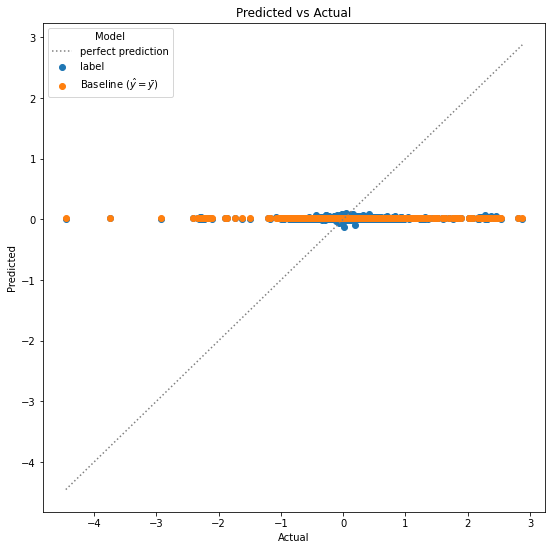

In [51]:
model.print_predicted_vs_actual(values, "composite_model", "Linear Regression Model By County")

In [52]:
mse_comb = values.apply(lambda col: sklearn.metrics.mean_squared_error(values.actual, col))
mse_comb

actual             0.000000
baseline           0.025555
composite_model    0.025508
dtype: float64

## Evaluate

In [53]:
mse = predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual, col))
mse.loc["composite_model"] = mse_comb.composite_model
mse

actual               0.000000
baseline             0.024951
linear_regression    0.024920
random_forest        0.015705
composite_model      0.025508
dtype: float64

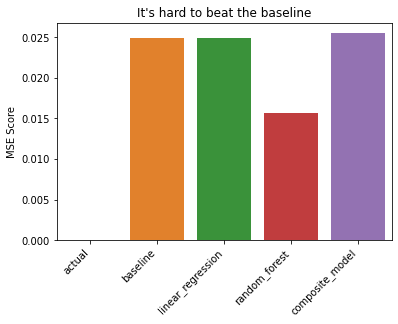

In [54]:
explore.compare_mse_scores(mse)

# Test

We see from the graph that our first linear regression model barely outperforms the baseline. As such, we will select it as our best model, and run it agains the test dataset, to ensure that it is not over fit.

In [56]:
features = ["age_home", "total_size", "value_ratio", "tax_rate_centroid", "roomcnt", "taxvaluedollarcnt"]
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = prepare.prepare_for_modeling(zillow, features)
lm, y_pred = model.run_lm(train_scaled, y_train)
score = lm.score(train_scaled, y_train)
score_v = lm.score(test_scaled, y_test)

print(f'''
      
The difference in r-squared score between two models is {(score - score_v)/score:.0%}

This is indicative that the model is not overfit
      
''')


      
The difference in r-squared score between two models is -193%

This is indicative that the model is not overfit
      



# Conclusion

After sereral model - we see actually that the best perfroming model is the linear_regression model. It is surprising, considering that it doesn't perform much better than the baseline. In fact, for this case, I would recommend using the baseline over any of the other models, just because of the computation work is does not provide a significantly higher pay-off.

Overall, we do reject our null hypothesis, as we see that our original thinking did help us accurately predict the logerror, but it was not enough to significantly improve our predictions.

### Key-takeaway ... Zillow's model is very good at what it does

### Further Imporvements:

* Do a more target approach when imputting. A lot of the missing values we filled with the mean or the mode, but it is worth doing more research to see if we can find a more relevant approach to calculate these values

* Do specific models by clustering - this can help us perhaps be more targeted by finding either locations or features that have more logerror variantion.